In [2]:
import getpass
import os
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

# 1. Chat model loading

Using a local open-source model in gguf format downloaded from HF. (**mixedbread-ai/mxbai-embed-large-v1**) It is a very small model with only 0.3B parameters (3-4 minutes to download on a Macbook)

This model has been chosen over two filters:
- Models with less than 3B parameters
- The ones supporting GGUF formats 
- The most downloaded model among the filtered ones

In [3]:
# Path to the model
local_model = "/Users/nayeongkim/Desktop/ML/localLLM/mxbai-embed-large-v1-f16.gguf"

In [4]:
import llama_cpp

In [5]:
import multiprocessing
from langchain_community.chat_models import ChatLlamaCpp

llm = ChatLlamaCpp(
    temperature=0.5,
    model_path=local_model,
    n_ctx=10000,
    n_gpu_layers=8,
    n_batch=300,  # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    max_tokens=512,
    n_threads=multiprocessing.cpu_count() - 1,
    repeat_penalty=1.5,
    top_p=0.5,
    verbose=True,
)

llama_model_load_from_file_impl: using device Metal (Apple M4 Pro) - 36863 MiB free
llama_model_loader: loaded meta data with 23 key-value pairs and 389 tensors from /Users/nayeongkim/Desktop/ML/localLLM/mxbai-embed-large-v1-f16.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = bert
llama_model_loader: - kv   1:                               general.name str              = mxbai-embed-large-v1
llama_model_loader: - kv   2:                           bert.block_count u32              = 24
llama_model_loader: - kv   3:                        bert.context_length u32              = 512
llama_model_loader: - kv   4:                      bert.embedding_length u32              = 1024
llama_model_loader: - kv   5:                   bert.feed_forward_length u32              = 4096
llama_model_loader: - kv   6:                 

# 2. Embedding loading

I'll use a small embedding, loading it directly from HuggingFace. (30 seconds)

In [6]:
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

/Users/nayeongkim/miniconda3/envs/ml_pf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 3. Indexing system

I chose Chroma, since I had a good experience of it using it directly from **ChromaDB** package.

In [7]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

In [8]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

USER_AGENT environment variable not set, consider setting it to identify your requests.


Total characters: 43047


In [9]:
print(docs[0].page_content[:300])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as i


In [10]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 63 sub-documents.


In [11]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['5dc496f0-7476-4f55-b373-b3bf0f52ce02', 'd187dde6-4768-42ce-ab60-28e9b806e8cd', '1b3b062c-93a7-47be-a1f4-56cbf89f6389']


In [12]:
from langchain import hub
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [13]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [14]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

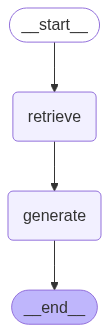

In [15]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
question = "What is Task Decomposition?"

retrieved_docs = vector_store.similarity_search(question)
docs_content = "\n\n".join(doc.page_content for doc in retrieved_docs)
prompt = prompt.invoke({"question": question, "context": docs_content})
answer = llm.invoke(prompt)

In [23]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

: 